<a href="https://www.inove.com.ar"><img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center"></a>


# Procesamiento de lenguaje natural
## Sentiment analysis con Embeddings + LSTM

### Objetivo
El objetivo es utilizar las críticas de compradores de ropa para que el sistema determine la evaluación del comprador y su crítica (cuantas estrellas le asigna al producto).

In [1]:
import numpy as np
import random
import io
import pickle
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow import keras
from tensorflow.keras import layers

from keras.utils.np_utils import to_categorical
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Embedding

### Datos
Utilizaremos como dataset críticas de compradores de ropa (eCommerce) los cuales puntuaron a cada prenda con un puntaje de 1 a 5 estrellas.\
Referencia del dataset: [LINK](https://www.kaggle.com/nicapotato/womens-ecommerce-clothing-reviews/version/1)

In [2]:
# Descargar la carpeta de dataset
import os
import gdown
if os.access('clothing_ecommerce_reviews.csv', os.F_OK) is False:
    url = 'https://drive.google.com/uc?id=1k2Dz4oY5uxI3JEaT6m-L2T2HvLkECYIP'
    output = 'clothing_ecommerce_reviews.csv'
    gdown.download(url, output, quiet=False)
else:
    print("El dataset ya se encuentra descargado")

Downloading...
From: https://drive.google.com/uc?id=1k2Dz4oY5uxI3JEaT6m-L2T2HvLkECYIP
To: /content/clothing_ecommerce_reviews.csv
100%|██████████| 8.48M/8.48M [00:00<00:00, 110MB/s]


In [3]:
# Armar el dataset
df = pd.read_csv('clothing_ecommerce_reviews.csv')
df.drop(columns = ['Unnamed: 0'], inplace = True)
df.head()

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


### 1 - Limpieza de datos
Alumno:
- Del dataset unicamente utilizar las columnas "Review Text" y "Rating.
- Tranformar el rating 1-5 a una escala numérica de 0 a 4.



In [4]:
df_reviews = df.loc[:, ['Review Text', 'Rating']].dropna()
df_reviews['Rating'] = df_reviews['Rating'] - 1
df_reviews.head()

,Review Text,Rating
0,Absolutely wonderful - silky and sexy and comf...,3
1,Love this dress! it's sooo pretty. i happene...,4
2,I had such high hopes for this dress and reall...,2
3,"I love, love, love this jumpsuit. it's fun, fl...",4
4,This shirt is very flattering to all due to th...,4


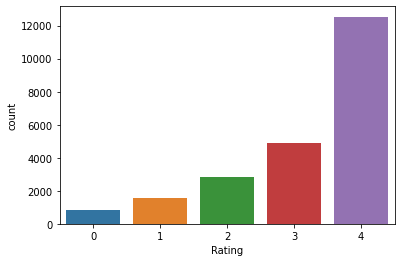

In [5]:
# Alumno: Observar como está distribuido el dataset respecto a la columna Rating
# es decir, observar que tan balanceado se encuentra respecot a cada clase

sns.countplot(x='Rating', data=df_reviews)
plt.show()

Podemos ver que el dataset no se encuentra muy balanceado, con muy poco rating para la crítica 0 y mucho para la critica de valor 4. 

In [6]:
# Alumno: tomar la columna de las review y almacenarlo todo en un vector numpy de reviews
text_sequences = df_reviews['Review Text'].values

In [7]:
# Alumno: Cuantas reviews (rows) hay para evaluar?
text_sequences.shape

(22641,)

In [8]:
# Alumno: Concatenar todas las reviews para armar el corpus
corpus = ' '.join(text_sequences)

In [9]:
# Alumno: ¿Cuál es la longitud de ese corpus?
len(corpus)

7011643

In [10]:
# Alumno: Utilizar "text_to_word_sequence" para separar las palabras en tokens
# recordar que text_to_word_sequence automaticamente quita los signos de puntuacion y pasa el texto a lowercase
from keras.preprocessing.text import text_to_word_sequence
tokens = text_to_word_sequence(corpus)

In [11]:
# Alumno: Dar un vistazo a los primeros 20 tokens/palabras
tokens [:20]

['absolutely',
 'wonderful',
 'silky',
 'and',
 'sexy',
 'and',
 'comfortable',
 'love',
 'this',
 'dress',
 "it's",
 'sooo',
 'pretty',
 'i',
 'happened',
 'to',
 'find',
 'it',
 'in',
 'a']

In [12]:
# Alumno: ¿Cuántos tokens/palabras hay?
len(tokens)

1372203

Pasamos de 7 millones a 1,3 millones, porque sacamos los símbolos, los espacios y otras cosas que estaban en el medio

Ahora armamos el tokenizador. Necesitamos obtener nuestro vocabulario y ID's del vocabulario. 

In [13]:
# Alumno: Tokenizar las palabras con el Tokenizer de Keras
# Definir una máxima cantidad de palabras a utilizar:
# num_words --> the maximum number of words to keep, based on word frequency.
# Only the most common num_words-1 words will be kept.
from keras.preprocessing.text import Tokenizer
num_words = 1500
vocab_size = num_words
tok = Tokenizer(num_words=2000) 
tok.fit_on_texts(tokens)

In [14]:
# Alumno: Obtener el diccionario de palabra (word) a índice
# y observar la cantidad total del vocabulario
word_index = tok.word_index
len(word_index)

14847

Tenemos 14.847 IDs. Vemos un poco como es, al ver que cada palabra tiene un ID


In [15]:
tok.word_index

{'the': 1,
 'i': 2,
 'and': 3,
 'a': 4,
 'it': 5,
 'is': 6,
 'this': 7,
 'to': 8,
 'in': 9,
 'but': 10,
 'on': 11,
 'for': 12,
 'of': 13,
 'with': 14,
 'was': 15,
 'so': 16,
 'my': 17,
 'dress': 18,
 'not': 19,
 'that': 20,
 'love': 21,
 'size': 22,
 'very': 23,
 'have': 24,
 'top': 25,
 'fit': 26,
 'are': 27,
 'like': 28,
 'be': 29,
 'as': 30,
 'me': 31,
 'wear': 32,
 "it's": 33,
 'great': 34,
 'too': 35,
 "i'm": 36,
 'or': 37,
 'am': 38,
 'just': 39,
 'you': 40,
 'would': 41,
 'they': 42,
 'up': 43,
 'at': 44,
 'fabric': 45,
 'small': 46,
 'color': 47,
 'look': 48,
 'if': 49,
 'more': 50,
 'really': 51,
 'ordered': 52,
 'little': 53,
 'perfect': 54,
 'will': 55,
 'one': 56,
 'these': 57,
 'flattering': 58,
 'well': 59,
 'an': 60,
 'soft': 61,
 'out': 62,
 'back': 63,
 'because': 64,
 'had': 65,
 'can': 66,
 '\r': 67,
 'comfortable': 68,
 'cute': 69,
 'nice': 70,
 'than': 71,
 'bought': 72,
 'beautiful': 73,
 'when': 74,
 'all': 75,
 'looks': 76,
 'bit': 77,
 'fits': 78,
 'large': 79,

In [16]:
# Alumno: Convertir las palabras/tokens a números
sequences = tok.texts_to_sequences(text_sequences)

In [17]:
# Alumno: Determinar cual es la oración más larga
max(len(s) for s in sequences)

115

Esta bien el tamaño, nuestra RAM está protegida. Nos quedamos con este tamaño de informacion, y el padding lo limitamos a ese largo para las demás. 

In [18]:
# Alumno: Realizar padding de las sentencias al mismo tamaño
# tomando de referencia la máxima sentencia
from keras.preprocessing.sequence import pad_sequences
maxlen = 115

In [19]:
# Al realizar padding obtener la variable "X" (input)
X = pad_sequences(sequences, padding='pre', maxlen=maxlen) #ponemos los ceros a izquierda

In [20]:
# Alumno: Observar las dimensiones de la variable input
X.shape

(22641, 115)

Son 22641 documentos, todos ahora con el mismo tamaño.

In [21]:
# Alumno tomar la columna rating y alcemacenarla en una variable "y" transformada a oneHotEncoding
# Su shape debe ser equivalente la cantidad de rows del corpus y a la cantidad de clases que se deseen predecir
# cantidad de palabras definidas para el vocabulario (vocab_size) (en este ejemplo 5)

y = pd.get_dummies(df_reviews.Rating, prefix='Rating')
print(y.shape)


(22641, 5)


In [22]:
# Alumno: Dividir los datos en train y test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [23]:
# Alumno: determinar la dimensiones de entrada y salida

# Alumno: determinar la dimensiones de entrada y salida
in_shape = X_train.shape[1] # max input sentence len
out_shape = y_train.shape[1] # multi class classification
print("in_shape", in_shape, ", out_shape", out_shape)

in_shape 115 , out_shape 5


### 2 - Entrenar el modelo con Embeddings + LSTM

In [24]:
# Alumno: Entrene su modelo con LSTM entrenando sus propios embeddings
# o utilizando embeddings pre-entrenados.
from keras.layers import LSTM
from keras.layers import Embedding
from keras.layers import Dropout

In [25]:
model = Sequential()
# input_dim = vocab_size (max n_words) Sería el máximo ID que puede recibir el sistema. vocab_size + 1 porque el ID = 0 corresponde a la "no palabra"
# input_length = setencias con padding a 200
# output_dim = 25 --> crear embeddings de tamaño 25. El número es mayor mientras mayor sea la cantidad de filas que tenemos 
model.add(Embedding(input_dim=vocab_size+1, output_dim=25, input_length=in_shape))
model.add(LSTM(units=64, return_sequences=True))  #se pone True porque tengo más de una capa LSTM
model.add(Dropout(0.2)) #para regularizar un poco
model.add(LSTM(units=64)) # La última capa LSTM no lleva return_sequences

model.add(Dense(units=128, activation='relu'))
model.add(Dropout(rate=0.2))
model.add(Dense(units=out_shape, activation='sigmoid'))

model.compile(optimizer="adam",
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 115, 25)           37525     
_________________________________________________________________
lstm (LSTM)                  (None, 115, 64)           23040     
_________________________________________________________________
dropout (Dropout)            (None, 115, 64)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense (Dense)                (None, 128)               8320      
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 6

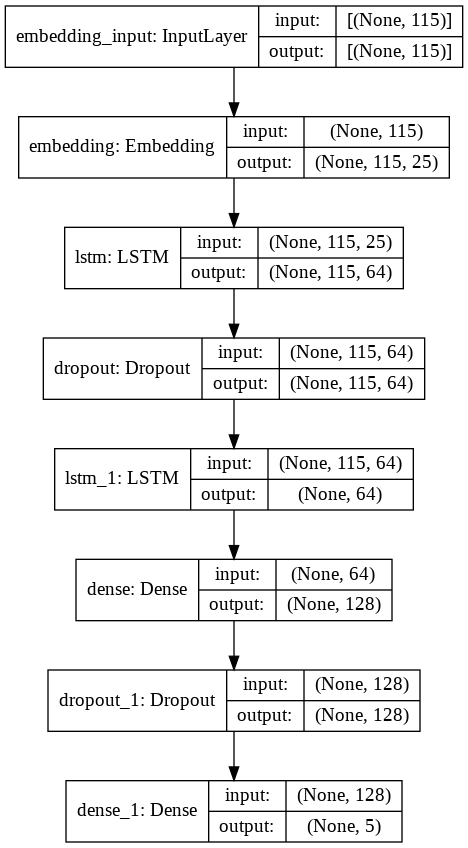

In [26]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [27]:
  hist = model.fit(X_train, y_train, epochs=5, validation_split=0.2)

Epoch 1/5
453/453 [==============================] - 34s 57ms/step - loss: 0.4076 - accuracy: 0.5520 - val_loss: 0.3717 - val_accuracy: 0.5639
Epoch 2/5
453/453 [==============================] - 25s 56ms/step - loss: 0.3278 - accuracy: 0.5966 - val_loss: 0.3185 - val_accuracy: 0.6150
Epoch 3/5
453/453 [==============================] - 25s 56ms/step - loss: 0.3037 - accuracy: 0.6274 - val_loss: 0.3117 - val_accuracy: 0.6210
Epoch 4/5
453/453 [==============================] - 25s 55ms/step - loss: 0.2923 - accuracy: 0.6451 - val_loss: 0.3108 - val_accuracy: 0.6172
Epoch 5/5
453/453 [==============================] - 25s 55ms/step - loss: 0.2837 - accuracy: 0.6526 - val_loss: 0.3131 - val_accuracy: 0.6139


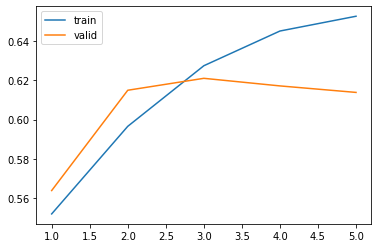

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
epoch_count = range(1, len(hist.history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=hist.history['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=hist.history['val_accuracy'], label='valid')
plt.show()

In [29]:
model.evaluate(X_test, y_test)

142/142 [==============================] - 3s 19ms/step - loss: 0.2978 - accuracy: 0.6388


[0.2977997362613678, 0.6387723684310913]

Comentarios finales: 

1 - el modelo dio un poco menos de accuracy con embeddings de 25 que con 50. Se podría probar con valores mayores a ver si mejoran los resultados.

2 - a partir de la época 3 empieza a hacer overfitting. 

3 - con mayor RAM se podría usar un vocabulario mayor, y mejorar los resultados. 

4 - Se pueden tomar embedding pre-entrenados, donde, si el contexto es medianamente parecido al actual, los resultos podrían ser mejores. Por ejemplo, con los de Glove o con los de Fasttext